## Imports ##

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import pandas as pd
import pickle
import numpy as np

#### Datasets

In [49]:
# drugs
drugs = pd.read_csv('./data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('./data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('./data/combinations.csv', index_col=0)

In [50]:
# reduce cell lines to the 2128 most important genes

with open('./data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [51]:
filtered_cell_lines

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
HCC1954,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,4.193197,3.967413,3.356586,5.688428,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
HCC1143,8.440833,8.005206,3.920152,3.210161,10.541755,2.877320,5.040755,6.764679,4.920267,5.519528,...,4.663152,3.235018,6.002967,6.837048,3.135009,3.479925,3.393041,7.479672,3.238828,2.564325
HCC1187,5.551352,5.032812,3.528140,3.247300,10.967920,2.934802,4.944361,2.851308,3.645263,5.802317,...,4.656409,5.170385,6.394137,6.492606,3.192293,3.580566,6.013642,8.186395,3.350337,2.914548
HCC1395,8.245466,5.650228,4.185011,3.259254,11.115642,2.933936,5.516593,3.286230,3.768223,5.700710,...,5.917166,3.719701,5.434950,6.151482,3.192478,3.430052,3.542136,8.426703,3.334150,2.641512
HCC1599,7.464137,6.321866,3.531019,5.513162,11.556747,2.998914,4.427619,4.466376,3.336529,6.209780,...,5.204575,6.172346,6.329224,7.900965,2.989608,3.189426,5.394498,8.710373,3.201282,2.749716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCC010,8.031837,6.249088,3.978721,2.909780,11.181177,2.976709,4.335160,3.422648,3.871866,5.911000,...,3.595436,2.765286,5.695328,7.166143,2.982351,3.260054,3.129891,8.034300,3.532607,2.621257
RCC-JW,7.988237,4.217507,3.394038,2.684415,10.388300,3.006199,5.041662,3.457660,7.311520,4.917703,...,3.836706,4.589799,5.231567,6.250817,2.912933,3.436972,3.731778,8.165442,3.789976,2.609469
MM1S,6.453126,5.564713,3.394151,3.028858,11.651180,3.102640,5.167779,2.848341,4.205521,6.021638,...,3.983349,4.146940,5.640954,6.672501,3.203864,3.294515,4.703204,8.485069,3.427507,2.669626
SNU-61,8.947314,6.013510,3.725530,3.029182,11.244912,3.123017,4.957366,5.788725,4.130588,6.112583,...,4.522754,2.724952,5.866326,5.720577,3.067657,3.452590,3.529156,8.440759,3.312884,2.772584


### Merge data

In [52]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [53]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_fingerprint)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [54]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vinblastine,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
Cisplatin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
Docetaxel,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GSK591,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,1,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,1,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,1,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,1,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


### Dataset splitting ###

In [56]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)
input_features = input.columns


In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(input)
input = scaler.transform(input)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3, random_state=42)

In [59]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64420, 3113), (64420,), (27609, 3113), (27609,))

In [60]:
x_train

array([[-0.18283847, -0.63563894, -0.28043898, ...,  0.34344969,
         1.63340617,  0.15043122],
       [-0.18283847,  1.57322017,  3.56583808, ...,  1.68354219,
         0.13663455, -0.32071857],
       [-0.18283847, -0.63563894, -0.28043898, ...,  1.50325089,
        -1.19716233,  0.12125234],
       ...,
       [ 5.46930851, -0.63563894, -0.28043898, ...,  0.92037309,
        -0.47683105, -0.41535663],
       [-0.18283847,  1.57322017, -0.28043898, ...,  0.61397913,
         0.60335476, -0.3900697 ],
       [-0.18283847,  1.57322017, -0.28043898, ...,  1.34199349,
        -0.86179568,  0.13567171]])

# Machine learning Models

### linear

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('MSE: ', mean_squared_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('R2: ', r2_score(y_test, y_pred_lr))







Linear Regression
MAE:  0.8841251494519614
MSE:  1.417556218963516
RMSE:  1.190611699490441
R2:  0.8129226562372869


In [62]:
# # grid search with linear regression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# param_grid = {'fit_intercept':[True,False],
#               'positive':[True, False]}


# grid = GridSearchCV(LinearRegression() ,param_grid, cv=5, verbose=3)
# grid.fit(x_train, y_train)

In [63]:
# # summarize the results of the grid search
# print("Best Score: {}".format(grid.best_score_))
# print("Best params: {}".format(grid.best_params_))

# # store best model in a variable
# best_model = grid.best_estimator_

# # predict using best model
# y_pred = best_model.predict(x_test)

# # evaluate predictions
# print('Linear Regression')
# print('MAE: ', mean_absolute_error(y_test, y_pred))
# print('MSE: ', mean_squared_error(y_test, y_pred))
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('R2: ', r2_score(y_test, y_pred))






### Gradient Boosting Regressor

In [64]:
#histogram based gradient boosting regressor
from sklearn.ensemble import HistGradientBoostingRegressor

hist = HistGradientBoostingRegressor()
hist.fit(x_train, y_train)
y_pred_gbr = hist.predict(x_test)
print('Histogram Based Gradient Boosting Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_gbr))
print('MSE: ', mean_squared_error(y_test, y_pred_gbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('R2: ', r2_score(y_test, y_pred_gbr))




Histogram Based Gradient Boosting Regressor
MAE:  0.8497637914911135
MSE:  1.2843943485948774
RMSE:  1.1333112320077294
R2:  0.830496258374389


### XGBoost regressor

In [71]:
import xgboost as xgb

xgbr_gpu = xgb.XGBRegressor(tree_method='hist', device= 'cuda')

# Train the model on GPU
xgbr_gpu.fit(x_train, y_train)

# Make predictions on the test set
y_pred_xgbr = xgbr_gpu.predict(x_test)
print('XGBoost Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_xgbr))
print('MSE: ', mean_squared_error(y_test, y_pred_xgbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xgbr)))
print('R2: ', r2_score(y_test, y_pred_xgbr))



XGBoost Regressor
MAE:  0.8312733342399194
MSE:  1.2265886316361643
RMSE:  1.1075146191523453
R2:  0.8381249787300743


### AdaBoost Regressor

In [72]:
# from sklearn.ensemble import AdaBoostRegressor

# ada = AdaBoostRegressor()
# ada.fit(x_train, y_train)
# y_pred_ada = ada.predict(x_test)
# print('Ada Boost Regressor')
# print('MAE: ', mean_absolute_error(y_test, y_pred_ada))
# print('MSE: ', mean_squared_error(y_test, y_pred_ada))
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_ada)))
# print('R2: ', r2_score(y_test, y_pred_ada))



### SVR

In [73]:
# svr = SVR()
# svr.fit(x_train, y_train)
# y_pred_svr = svr.predict(x_test)
# print('SVR')
# print('MAE: ', mean_absolute_error(y_test, y_pred_svr))
# print('MSE: ', mean_squared_error(y_test, y_pred_svr))
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_svr)))
# print('R2: ', r2_score(y_test, y_pred_svr))


## Model plots

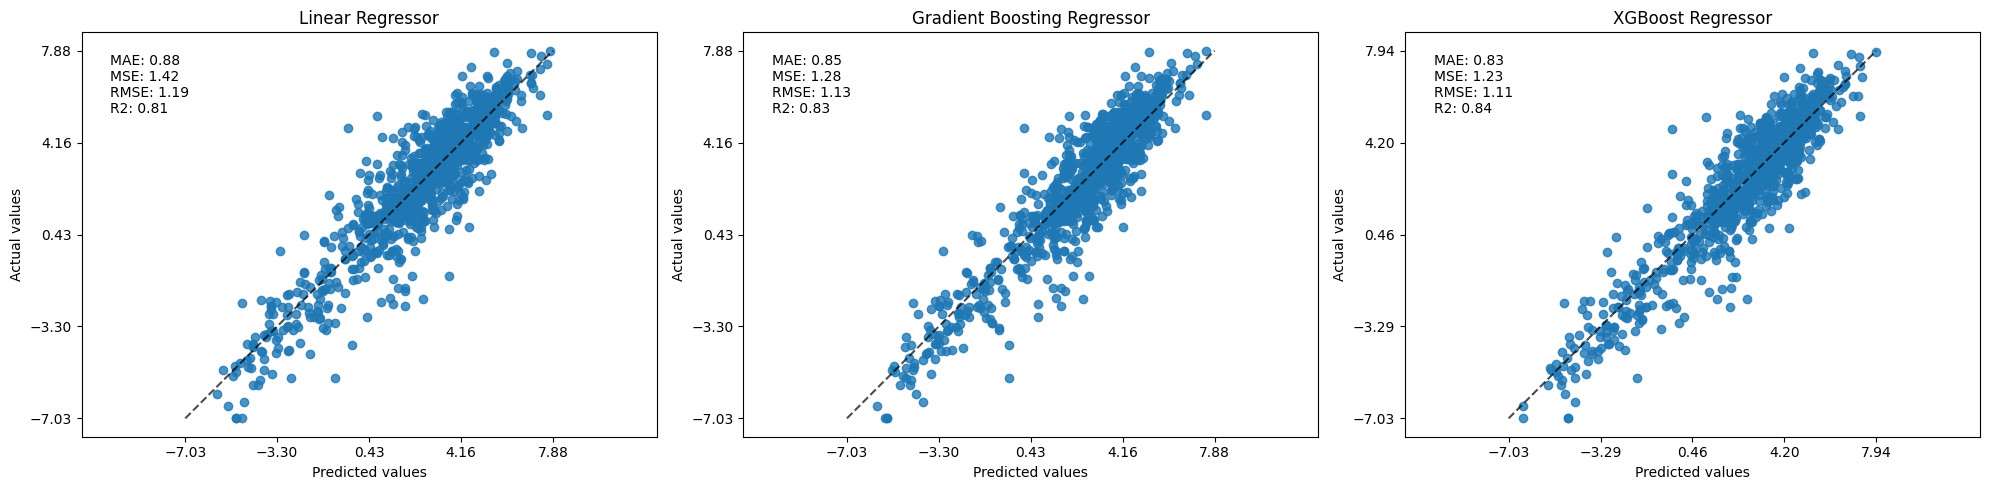

In [74]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Linear Regressor")
axs[0].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_lr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}\nR2: {r2_score(y_test, y_pred_lr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Gradient Boosting Regressor")
axs[1].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_gbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_gbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr)):.2f}\nR2: {r2_score(y_test, y_pred_gbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_xgbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[2],
    random_state=0,
)
axs[2].set_title("XGBoost Regressor")
axs[2].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_xgbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_xgbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgbr)):.2f}\nR2: {r2_score(y_test, y_pred_xgbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

# fig.suptitle("")
plt.tight_layout()
plt.show()

## SHAP analysis

[14:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


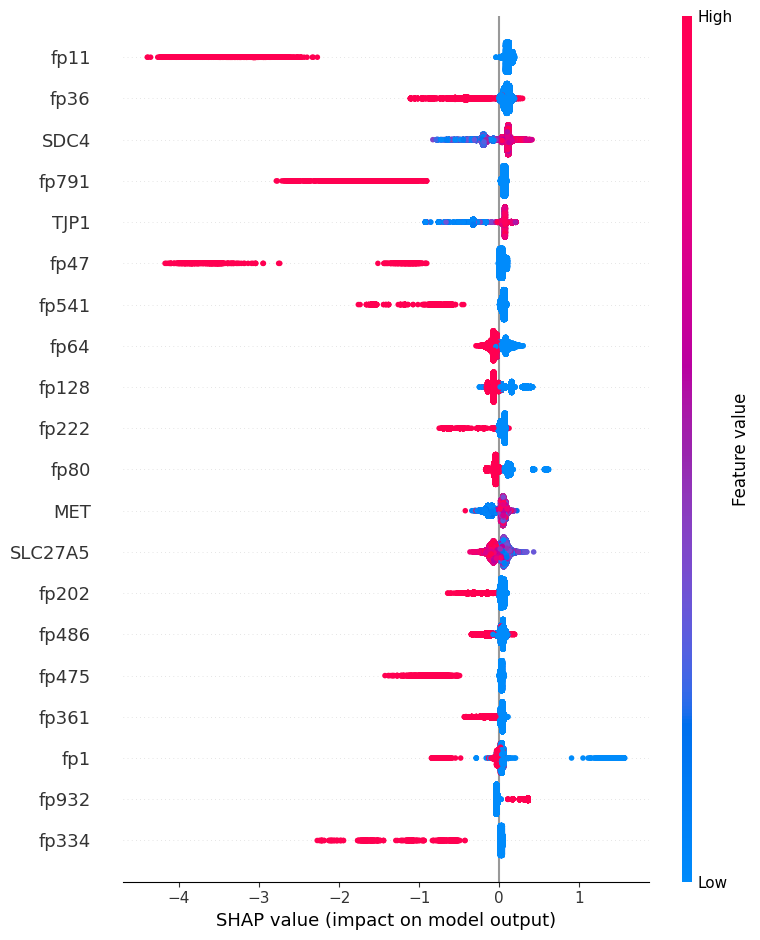

In [75]:

import shap
# SHAP analysis
explainer = shap.Explainer(xgbr_gpu)
shap_values = explainer.shap_values(x_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, x_test, feature_names=input_features)
